In [3]:
import rdkit
from rdkit import Chem, DataStructs
import numpy as np
from rdkit.Chem import AllChem
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = []
label = np.empty((0,1), dtype=float)

f = open("data/logP_labels.csv")
header = f.readline()

count = 0
for line in f :
    parts = line.strip().split(',')
    smiles = parts[1]
    mol = Chem.MolFromSmiles(smiles)
    
    # Create the fingerprint and append it to data array
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    data.append(arr)
    # Get the kow and append to target data array
    kow = float(parts[-1])
    label = np.append(label, kow)
    count = count+1
#    if count == 10000:
#        break
f.close()

In [5]:
data = np.asarray(data)
print(tf.__version__)
s = 12000
train_data = data[:s, :]
train_label = label[:s]

test_data = data[s:, :]
test_label = label[s:]
print(train_data.shape)
print(train_label.shape)

print(test_data.shape)
print(test_label.shape)

2.3.0
(12000, 1024)
(12000,)
(2176, 1024)
(2176,)


In [6]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(512, activation=tf.nn.relu,
                           input_shape=(train_data.shape[1],)),
        keras.layers.Dense(512, activation=tf.nn.relu),
        #keras.layers.Dense(512, activation=tf.nn.relu),
        keras.layers.Dense(256, activation=tf.nn.relu),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop()
    optimizer = tf.keras.optimizers.SGD()

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%100 == 0 : print('')
        print('.', end='')



def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    #plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
    plt.plot(history.epoch, np.array(history.history['mae']),
             label='Train loss')
    #plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
    plt.plot(history.epoch, np.array(history.history['val_mae']),
         label='Val loss')
    plt.legend()
    #plt.ylim([])
    
EPOCHS = 80

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 960,001
Trainable params: 960,001
Non-trainable params: 0
__________________________________________________

In [8]:
history = model.fit(train_data, train_label, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])




................................................................................

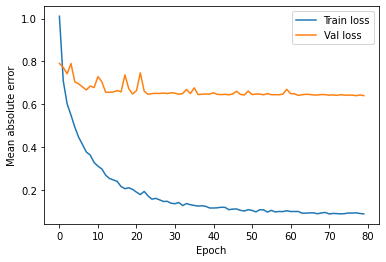

In [9]:
plot_history(history)

In [10]:
[loss, mae] = model.evaluate(test_data, test_label, verbose=0)
print("Testing set Mean Abs Error : ", mae)

test_predictions = model.predict(test_data).flatten()

Testing set Mean Abs Error :  0.8196730613708496


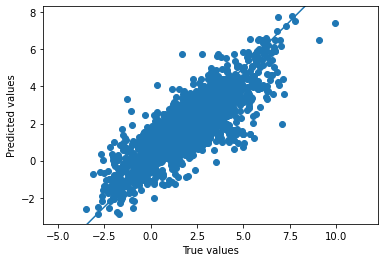

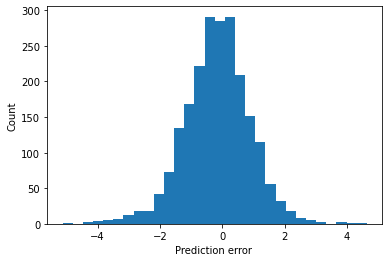

In [11]:
plt.figure()

plt.scatter(test_label, test_predictions)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-10, 10], [-10,10])

error = test_predictions - test_label
plt.figure()
plt.hist(error, bins = 30)
plt.xlabel("Prediction error ")
_ = plt.ylabel(("Count"))

In [12]:
# SAMPL
sampl_data = []
sampl_label = []

f = open("test/sampl7.csv")
header = f.readline()
for line in f:
    parts = line.strip().split(',')
    smiles = parts[1]
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    arr=np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    sampl_data.append(arr)
    #kow = float(parts[-1])
    #sampl_label.append(kow)
sampl_data = np.asarray(sampl_data)
sampl_label = np.asarray(sampl_label)
#print(sampl_label.shape)
print(sampl_data.shape)

(22, 1024)


In [13]:
test_predictions = model.predict(sampl_data).flatten()

In [14]:
test_predictions

array([1.5310318 , 1.4972856 , 1.0585426 , 1.7368863 , 1.3604562 ,
       2.383608  , 2.8461847 , 1.0898268 , 2.4256852 , 2.6521542 ,
       2.0386398 , 3.4640012 , 3.5307176 , 0.789028  , 1.9264691 ,
       2.4786909 , 2.3469338 , 1.4882786 , 2.0962555 , 0.77046007,
       1.1008649 , 1.0022874 ], dtype=float32)